In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import sys
import matplotlib as mpl


sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('algo_syn', None)
from algo_syn import *

sys.modules.pop('ARW', None)
from ARW import *

15
69


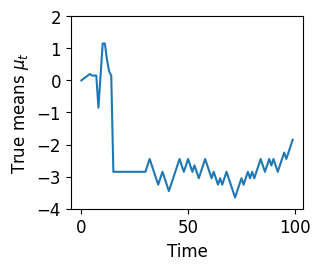

In [5]:
num_periods = 100
seed = 2024
np.random.seed(seed)

B_arr_val = np.random.randint(low=2, high=5, size=num_periods)
B_arr_train = 3 * B_arr_val

####THIS IS THE FUNCTION USED IN EXAMPLE 1 OF THE PAPER#######
figname= 'horizontal'
num_periods = 100
true_means = np.ones(num_periods) * 5

####THIS IS THE FUNCTION USED IN EXAMPLE 2 OF THE PAPER#######
figname = 'combination'
num_periods = 100
true_means = 10 * generate_syn_data(num_periods-1, 2)
 
params= {'font.size': 12}
mpl.rcParams.update(params)
plt.figure(figsize=(3,2.5))
plt.plot(true_means)
plt.xlabel('Time')
plt.ylabel(r'True means $\mu_t$')
plt.yticks([-4,-3,-2,-1,0,1,2])

#change figure name accordingly
plt.savefig(f'./figures/true_means_{figname}.png', bbox_inches='tight', dpi=300)

In [10]:
window_sizes_train = [1, 4, 16, 64, 256]
window_sizes_val = [1, 4, 16, 64, 256]

#ARW parameters
delta = 0.1; M = 0; seed = 2024

#variance schemes
variances = [1,10]

#20 trials per variance
trials_per_var = 20

#seeds for the trials
seeds = np.arange(len(variances) * trials_per_var)

In [11]:
#initialize dictionary
MSE_dict = {}
MSE_dict['ARW'] = {}
for k in window_sizes_val:
    MSE_dict[f'Val_{k}'] = {}
    for variance in variances:
        MSE_dict[f'Val_{k}'][variance] = {}
        MSE_dict['ARW'][variance] = {}
        for trial in range(trials_per_var):
            MSE_dict[f'Val_{k}'][variance][trial] = []
            MSE_dict['ARW'][variance][trial] = []

#for each trial: sample data, train models, select models, calculate excess risk
for (trial, seed) in tqdm(enumerate(seeds)):

    np.random.seed(seed)

    variance_noise = variances[trial // trials_per_var]

    #sample data for training and validation
    X_train = generate_gaussian_sequence(B_arr=B_arr_train, true_means=true_means, variance=variance_noise)
    X_val = generate_gaussian_sequence(B_arr=B_arr_val, true_means=true_means, variance=variance_noise)

    B_arr_train_starts = np.cumsum(B_arr_train) - B_arr_train
    B_arr_train_ends = np.cumsum(B_arr_train) - 1
    B_arr_val_starts = np.cumsum(B_arr_val) - B_arr_val
    B_arr_val_ends = np.cumsum(B_arr_val) - 1
    
    X_train_mean = []   
    
    for t in range(num_periods):
        
        #get the true mean in the t^th period
        mu_t = true_means[t]

        #get the first t periods of training and validation data
        X_train_t = X_train[:B_arr_train_ends[t]+1]
        B_arr_train_t = B_arr_train[:t+1]
        X_val_t = X_val[:B_arr_val_ends[t]+1]
        B_arr_val_t = B_arr_val[:t+1]

        #(for plotting) record the training mean in the t^th period
        X_train_mean.append(np.mean(X_train_t[-B_arr_train_t[-1]:]))

        #train fixed-window models
        models = train_synthetic(X_train_t, B_arr_train_t, window_sizes_train)
        
        #model selection using fixed-window validation data
        indices_selected, models_selected = select_synthetic_fixed(X_val_t, B_arr_val_t, models, window_sizes_val)

        for (i, k) in enumerate(window_sizes_val):
            
            mu_hat_fixed_i = models_selected[i]
            MSE_dict[f'Val_{k}'][variance_noise][trial % trials_per_var].append((mu_t - mu_hat_fixed_i)**2)
            
        #model selection using ARW
        idx_ARW, mu_hat_ARW = select_synthetic_ARW(X_val_t, B_arr_val_t, models, delta, M, seed)

        #record SQUARE ERRORS
        MSE_dict['ARW'][variance_noise][trial % trials_per_var].append((mu_t - mu_hat_ARW)**2)
        
    """ #Plot X_val_mean
    plt.figure(figsize=(3,2.5))
    plt.plot(X_train_mean)
    plt.title('X_train_mean')
    plt.show() """

40it [00:44,  1.12s/it]


In [12]:
methods = ['ARW'] + [f'Val_{k}' for k in window_sizes_val]
num_methods = len(methods)

#save dictionary to nparray
MSE_array = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
rel_error = np.zeros((len(methods), len(variances), trials_per_var, num_periods))
for (i, key) in enumerate(MSE_dict.keys()):
    for (j, variance) in enumerate(MSE_dict[key].keys()):
        for (trial, trial_MSE) in MSE_dict[key][variance].items():

            #record SQUARE ERRORS
            MSE_array[i, j, trial, :] = trial_MSE

#take average of mse over time and trials for each variance (n_model * n_variance)
mse_mean_over_variances = np.mean(np.mean(MSE_array, axis=3), axis=2)
print(mse_mean_over_variances.shape)

#take average of mse over for each trial (n_model * n_variance * n_periods)
mse_mean_over_trials = np.mean(MSE_array, axis=2)
print(mse_mean_over_trials.shape)

(6, 2)
(6, 2, 100)


[0.01505914 0.04251311 0.02511315 0.01340073 0.00992641 0.01004731]
[1.29260665 4.11720648 2.57221189 1.39608199 1.01460084 0.98171329]


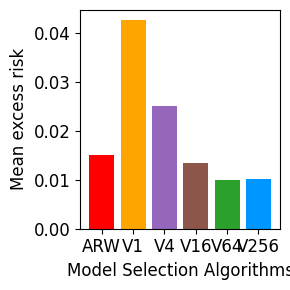

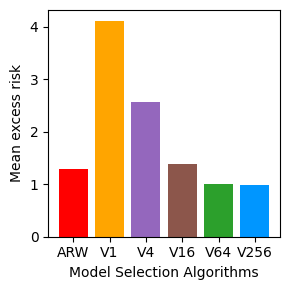

In [13]:
#create subplots for each variance
colors = ['r', '#FFA500', 'tab:purple', 'tab:brown', 'tab:green', '#0096FF']
# Iterate over variances
for (idx, variance) in enumerate(variances):
    fig, ax = plt.subplots(1, 1, figsize = (3, 3))    
    # Plot bars for mean MSE of each method
    ax.bar(range(num_methods), mse_mean_over_variances[:, idx], color=colors, \
           width = 0.8)
    print(mse_mean_over_variances[:, idx])
    # Set labels and title
    ax.set_xlabel('Model Selection Algorithms')
    #ax.set_title(f'Variance $\sigma^2$={variance}')
    ax.set_xticks(range(num_methods))
    ax.set_xticklabels(['ARW', 'V1', 'V4', 'V16', 'V64', 'V256'])
    ax.set_ylabel('Mean excess risk')

    #adjust fontsizes
    mpl.rcParams.update({'font.size': 10})
    plt.tight_layout()

    #change figure name accordingly
    plt.savefig(f'./figures/{figname}_var{variance}.png', dpi=300, bbox_inches='tight')



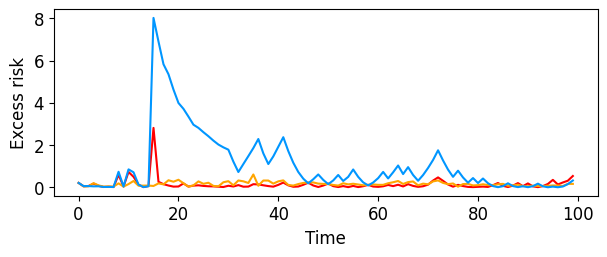

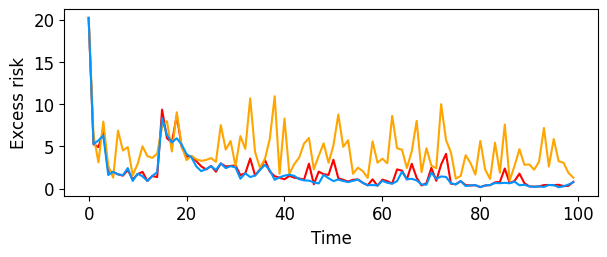

In [13]:
#plot MSE over time periods
for v, variance in enumerate(variances):
    fig, ax = plt.subplots(1, 1, figsize = (6, 2.5))
    #ARW
    plt.plot(mse_mean_over_trials[0][v], color='r', label='ARW')
    #Val_1
    plt.plot(mse_mean_over_trials[1][v], color='#FFA500', label='V1')
    #val_all
    plt.plot(mse_mean_over_trials[-1][v], color='#0096FF', label='V256')
    mpl.rcParams.update({'font.size': 12})
    plt.tight_layout()
    #change figure name accordingly
    plt.ylabel('Excess risk')
    plt.xlabel('Time')
    plt.savefig(f'./figures/{figname}_time_var{variance}.png', dpi=300, bbox_inches='tight')
    #plt.legend()